In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

from collections import Counter
from wordcloud import WordCloud

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from keras.layers import SimpleRNN, Embedding, Dense, LSTM
from keras.models import Sequential, load_model
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import EarlyStopping

from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

import utils

import warnings
warnings.filterwarnings('ignore')

np.random.seed(1)

Using TensorFlow backend.


Mengambil ```data.csv``` dari direktori ```Dataset/``` yang berisi kumpulan data kalimat umpatan.

In [2]:
data = pd.read_csv('Dataset/data.csv')

Medefinisikan target kelas atau label pada data ```{0: Bukan-Umpatan, 1: Umpatan}```.

In [3]:
classes = ['Non-Offensive', 'Offensive']

In [4]:
data.head()

Text  Label
0  kalo gila jangan keterlaluan apa      1
1     gila banget sih lu jadi orang      1
2               ente ente yang gila      1
3                       budek lu ya      1
4                  jangan gitu nyet      1

In [5]:
def preprocessing(text):
    stopword = StopWordRemoverFactory().create_stop_word_remover()
    stemmer = StemmerFactory().create_stemmer()
    
    text = text.lower()
    text = re.sub(r' +', ' ', text)
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r'[0-9]+', '', text)
    text = re.sub(r'[^\w\s]',' ', text)
    
    text = stopword.remove(text)
    text = stemmer.stem(text)
    
    return text

In [6]:
data["Text"] = data["Text"].map(preprocessing)

In [7]:
data.head()

Text  Label
0   kalo gila jangan terlalu apa      1
1  gila banget sih lu jadi orang      1
2                 ente ente gila      1
3                       budek lu      1
4               jangan gitu nyet      1

In [8]:
X = data['Text'].values # Texts
y = data['Label'].values # Labels

In [9]:
def word_cloud(data, label, title):
    a = ' '.join(list(data[data['Label'] == label]['Text']))
    b = WordCloud(width = 512, height = 512, background_color="white").generate(a)
    plt.figure(figsize = (5, 4))
    plt.imshow(b)
    plt.title(title)
    plt.axis('off')
    plt.tight_layout(pad = 0)
    plt.show()

Menampilkan data yang dominan di tiap target kelas.

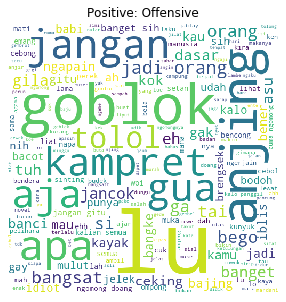

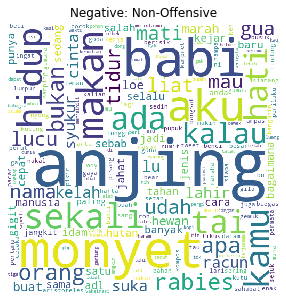

In [10]:
word_cloud(data, 1, 'Positive: Offensive')
word_cloud(data, 0, 'Negative: Non-Offensive')

Mebagi data menjadi data pelatihan dan pengujian.

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=3)

In [12]:
y_test.shape

(51,)

Mengubah setiap sampel data yang berupa kata atau kumpulan kata menjadi array yang berisi angka numerik.

In [13]:
def preprocessing(X, texts, maxlen=20):
    tokenizer = Tokenizer()   
    tokenizer.fit_on_texts(X)
    
    sequences = tokenizer.texts_to_sequences(texts)
    data = pad_sequences(sequences, maxlen=maxlen)
    
    return data

In [14]:
train_data = preprocessing(X, X_train)
test_data = preprocessing(X, X_test)

**Pemodelan Reccurent Neural Network (RNN)**

In [15]:
np.max(train_data)

668

In [16]:
model = Sequential()
model.add(Dense(16, input_dim=20, activation='sigmoid'))
model.add(Dense(8, activation='sigmoid'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])

model.summary()

W0714 22:26:51.339432 139837056747328 deprecation_wrapper.py:119] From /home/hssahrul/miniconda3/envs/ML/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0714 22:26:51.366951 139837056747328 deprecation_wrapper.py:119] From /home/hssahrul/miniconda3/envs/ML/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0714 22:26:51.371217 139837056747328 deprecation_wrapper.py:119] From /home/hssahrul/miniconda3/envs/ML/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0714 22:26:51.450837 139837056747328 deprecation_wrapper.py:119] From /home/hssahrul/miniconda3/envs/ML/lib/python3.7/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 16)                336       
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 9         
Total params: 481
Trainable params: 481
Non-trainable params: 0
_________________________________________________________________


In [17]:
es = EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='min', restore_best_weights=True, baseline=0.95)

In [18]:
history = model.fit(train_data, y_train, epochs=100, batch_size=32, validation_split=0.2, verbose=1, callbacks=[es])

W0714 22:26:51.978014 139837056747328 deprecation_wrapper.py:119] From /home/hssahrul/miniconda3/envs/ML/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.



Train on 361 samples, validate on 91 samples
Epoch 1/100
361/361 [==============================] - 1s 2ms/step - loss: 1.2987 - acc: 0.1634 - val_loss: 1.2282 - val_acc: 0.1319
Epoch 2/100
361/361 [==============================] - 0s 86us/step - loss: 1.1557 - acc: 0.1634 - val_loss: 1.1129 - val_acc: 0.1319
Epoch 3/100
361/361 [==============================] - 0s 99us/step - loss: 1.0519 - acc: 0.1634 - val_loss: 1.0199 - val_acc: 0.1319
Epoch 4/100
361/361 [==============================] - 0s 93us/step - loss: 0.9634 - acc: 0.1634 - val_loss: 0.9341 - val_acc: 0.1319
Epoch 5/100
361/361 [==============================] - 0s 87us/step - loss: 0.8853 - acc: 0.1634 - val_loss: 0.8589 - val_acc: 0.1319
Epoch 6/100
361/361 [==============================] - 0s 93us/step - loss: 0.8170 - acc: 0.1856 - val_loss: 0.7895 - val_acc: 0.2308
Epoch 7/100
361/361 [==============================] - 0s 92us/step - loss: 0.7560 - acc: 0.2992 - val_loss: 0.7285 - val_acc: 0.3626
Epoch 8/100
361/36

361/361 [==============================] - 0s 96us/step - loss: 0.4350 - acc: 0.8366 - val_loss: 0.3941 - val_acc: 0.8681
Epoch 62/100
361/361 [==============================] - 0s 95us/step - loss: 0.4350 - acc: 0.8366 - val_loss: 0.3938 - val_acc: 0.8681
Epoch 63/100
361/361 [==============================] - 0s 90us/step - loss: 0.4347 - acc: 0.8366 - val_loss: 0.3938 - val_acc: 0.8681
Epoch 64/100
361/361 [==============================] - 0s 84us/step - loss: 0.4344 - acc: 0.8366 - val_loss: 0.3940 - val_acc: 0.8681
Epoch 65/100
361/361 [==============================] - 0s 96us/step - loss: 0.4340 - acc: 0.8366 - val_loss: 0.3936 - val_acc: 0.8681
Epoch 66/100
361/361 [==============================] - 0s 90us/step - loss: 0.4341 - acc: 0.8366 - val_loss: 0.3933 - val_acc: 0.8681
Epoch 67/100
361/361 [==============================] - 0s 89us/step - loss: 0.4336 - acc: 0.8366 - val_loss: 0.3930 - val_acc: 0.8681
Epoch 68/100
361/361 [==============================] - 0s 90us/step

Melakukan evaluasi terhadap performa model RNN.

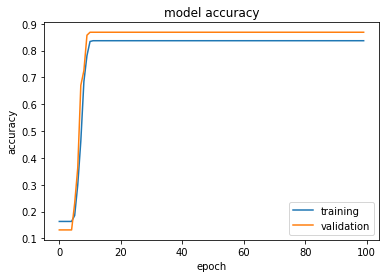

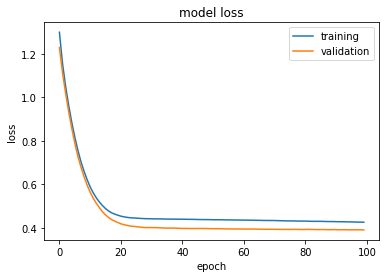

In [19]:
utils.plot_accuracy(history)
utils.plot_loss(history)

Kemampuan model untuk melakukan generalisasi pada data pengujian.

In [20]:
loss, acc = model.evaluate(test_data, y_test)
print('Loss: {:.2f}, Acc: {:.2f}'.format(loss, acc))

51/51 [==============================] - 0s 117us/step
Loss: 0.55, Acc: 0.76


In [21]:
y_pred = model.predict_classes(test_data)

In [22]:
confusion_matrix(y_test, y_pred)

array([[ 0, 12],
       [ 0, 39]])

In [23]:
y_pred = y_pred.reshape(51,)

df_y_cls = [classes[i] for i in y_test]
df_p_cls = [classes[j] for j in y_pred]

Menampilkan beberapa sampel data dan hasil prediksi dari model.

In [24]:
df_x = pd.DataFrame(X_test, columns=['Text'])
df_y = pd.DataFrame(df_y_cls, columns=['Actual'])
df_p = pd.DataFrame(df_p_cls , columns=['Predict'])

df_res = pd.concat([df_x, df_y, df_p], axis=1)

df_res.tail(10)

Text         Actual    Predict
41                     jancok kalian semua      Offensive  Offensive
42                   kurang ajar lu goblok      Offensive  Offensive
43                               eh anjing      Offensive  Offensive
44                                    babi  Non-Offensive  Offensive
45                           apasih anjing      Offensive  Offensive
46           jalan pake mata emang lo buta      Offensive  Offensive
47                               ga anjing      Offensive  Offensive
48                              babi kelah  Non-Offensive  Offensive
49        babi hutan salah satu jenis babi  Non-Offensive  Offensive
50  monyet kok mirip bani malu aja lu nyet      Offensive  Offensive

In [25]:
model.save('Model/Model-Iterasi-1.h5')

Melakukan prediksi pada data yang tidak pernah dilihat model.

In [26]:
unseen_text = ['anjingnya lucu kak']
unseen_text = preprocessing(X, unseen_text)

print('Predict: {} | Confidence: {:.2f}'.format(classes[model.predict_classes(unseen_text)[0][0]], 
                                          model.predict(unseen_text)[0][0]))

Predict: Offensive | Confidence: 0.84


Menggunakan model yang sudah di-train sebelumnya.

In [27]:
loaded_model = load_model('Model/Model-Iterasi-1.h5')

In [28]:
print('Predict: {} | Confidence: {:.2f}'.format(classes[model.predict_classes(unseen_text)[0][0]], 
                                          model.predict(unseen_text)[0][0]))

Predict: Offensive | Confidence: 0.84
